In [13]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,make_scorer
from keras.models import Sequential
from keras.layers import Dense, Dropout
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from keras.callbacks import EarlyStopping
import math
#from keras.wrappers.scikit_learn import KerasClassifier


In [14]:
path = '/Users/HP Spectre/OneDrive - student.kit.edu/uni/Master/Lissabon Kurse/Intelligent Systems/IntSysGroup6/'

data = pd.read_csv(path+'Project/data/robot_inverse_kinematics_dataset.csv')
X = data.iloc[:,6:].to_numpy()
y = data.iloc[:,0:6].to_numpy()
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()
X = scaler_X.fit_transform(X)
y = scaler_Y.fit_transform(y)
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42, test_size=0.2)

(15000, 6)


In [15]:
# Define a function to create the Keras model
def create_model(neurons,dropout_rate,hidden_layers):
    model = Sequential()
    input_dim = 3
    output_dim = 6
    model.add(Dense(neurons, input_dim=input_dim, activation='relu'))
    for _ in range(hidden_layers):
        model.add(Dense(neurons, activation='relu'))
        if dropout_rate > 0.0:
            model.add(Dropout(dropout_rate))
    model.add(Dense(output_dim))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

    return model



In [16]:

model = KerasRegressor(build_fn=create_model, epochs=20, batch_size=64, verbose=0,neurons=32,dropout_rate=0.0,hidden_layers= 2)

hidden_layers = [2, 3,4]
neurons = [32, 64, 128]
dropout_rate = [0.0,0.1,0.3]

param_grid = dict(neurons=neurons, hidden_layers=hidden_layers, dropout_rate=dropout_rate)



In [18]:
# Create a GridSearchCV instance

# TODO: Adjust scoring 
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_absolute_error')


grid_result = grid.fit(X_train, y_train)

C:\Users\HP Spectre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


In [26]:
%store grid
print("Best MAE: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
scaler_Y.inverse_transform([grid_result.best_score_])

INFO:tensorflow:Assets written to: C:\Users\HPSPEC~1\AppData\Local\Temp\tmpmulg27rc\assets


INFO:tensorflow:Assets written to: C:\Users\HPSPEC~1\AppData\Local\Temp\tmpmulg27rc\assets


Stored 'grid' (GridSearchCV)
Best MAE: -0.220089 using {'dropout_rate': 0.1, 'hidden_layers': 3, 'neurons': 128}


ValueError: Expected 2D array, got 1D array instead:
array=[-0.22008917].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [27]:
grid.cv_results_['mean_test_score']

array([-0.22652014, -0.22473062, -0.22306612, -0.22628767, -0.22351018,
       -0.22119872, -0.22537389, -0.22140607, -0.2206349 , -0.22740247,
       -0.22444427, -0.2222398 , -0.22516589, -0.22246738, -0.22008917,
       -0.22555205, -0.22274586, -0.22108803, -0.23269375, -0.22654741,
       -0.22330307, -0.23049695, -0.22587986, -0.22334608, -0.23520325,
       -0.22710719, -0.2235383 ])

In [8]:
grid.cv_results_['rank_test_score'] 

array([21, 16,  9, 18, 10,  4, 14,  6,  2, 19, 11,  7, 17,  8,  3, 15,  5,
        1, 24, 20, 13, 26, 23, 12, 27, 25, 22])

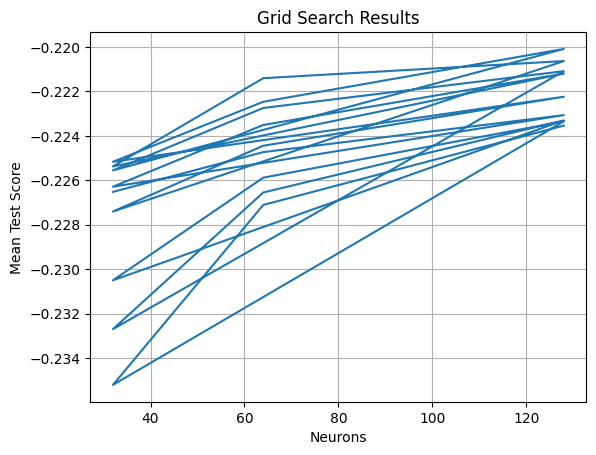

In [21]:
import matplotlib.pyplot as plt

# Access the hyperparameters and mean test scores
param_values = grid.cv_results_['param_neurons']
mean_test_scores = grid.cv_results_['mean_test_score']

# Plot the mean test scores against the hyperparameter values
plt.plot(param_values, mean_test_scores)
plt.xlabel('Neurons')
plt.ylabel('Mean Test Score')
plt.title('Grid Search Results')
plt.grid(True)
plt.show()


In [22]:
best_mae = -grid_result.best_score_  # The best MAE from the grid search
print("Best MAE in degrees:", best_mae)

Best MAE in degrees: 0.22008916705443385


In [28]:
results_df = pd.DataFrame(grid_result.cv_results_)
results_df.head()
results_df.to_csv('grid_search_results.csv', index=False)

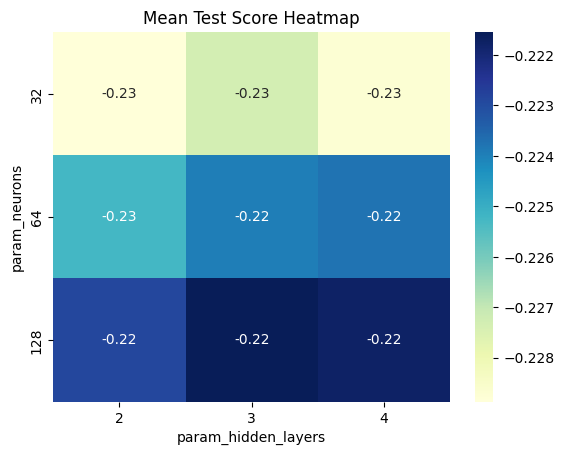

ValueError: x and y must have same first dimension, but have shapes (3,) and (9,)

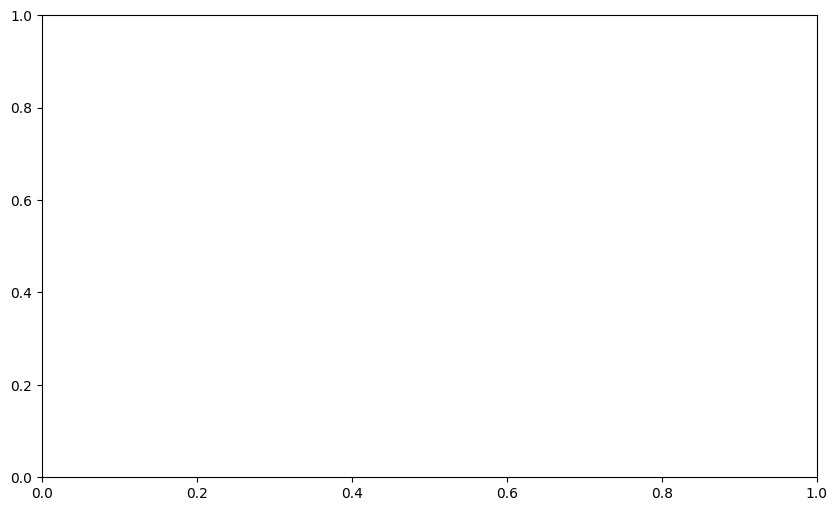

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert the grid search results to a DataFrame
results_df = pd.DataFrame(grid_result.cv_results_)

# Heatmap for mean test scores
pivot_table = results_df.pivot_table(values='mean_test_score', index='param_neurons', columns='param_hidden_layers')
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu')
plt.title('Mean Test Score Heatmap')
plt.show()

# Line plot for mean test scores with different dropout rates
plt.figure(figsize=(10, 6))
for dropout_rate in dropout_rate:
    mean_test_scores = results_df[results_df['param_dropout_rate'] == dropout_rate]['mean_test_score']
    plt.plot(neurons, mean_test_scores, marker='o', label=f'Dropout Rate {dropout_rate}')

plt.xlabel('Number of Neurons')
plt.ylabel('Mean Test Score (MAE)')
plt.title('Mean Test Score vs. Neurons with Different Dropout Rates')
plt.legend()
plt.grid(True)
plt.show()

# Bar plot for best parameters and their mean test scores
best_params = results_df.groupby('rank_test_score').first()
best_params = best_params[['param_neurons', 'param_hidden_layers', 'param_dropout_rate', 'mean_test_score']]
best_params = best_params.sort_values(by='mean_test_score')
sns.barplot(x=best_params.index, y=best_params['mean_test_score'])
plt.title('Best Parameters and Their Mean Test Scores')
plt.xlabel('Rank')
plt.ylabel('Mean Test Score (MAE)')
plt.show()
